#CO70058 Computer Vision
#Tutorial 4 - Hough Transform and Relaxation Labelling

References:
*   `Learning OpenCV 3` book

Let's study a bit the theory:

## Hough Line Transform

First, I recommend watching this [YouTube video](https://www.youtube.com/watch?v=4zHbI-fFIlI).

The Hough transform is a method for finding lines, circles, or other simple forms in an image. The original Hough transform was a line transform, which is a relatively fast way of searching a binary image for straight lines. The transform can be further generalized to cases other than just simple lines.

Every point in a binary image can be part of a set of possible lines.

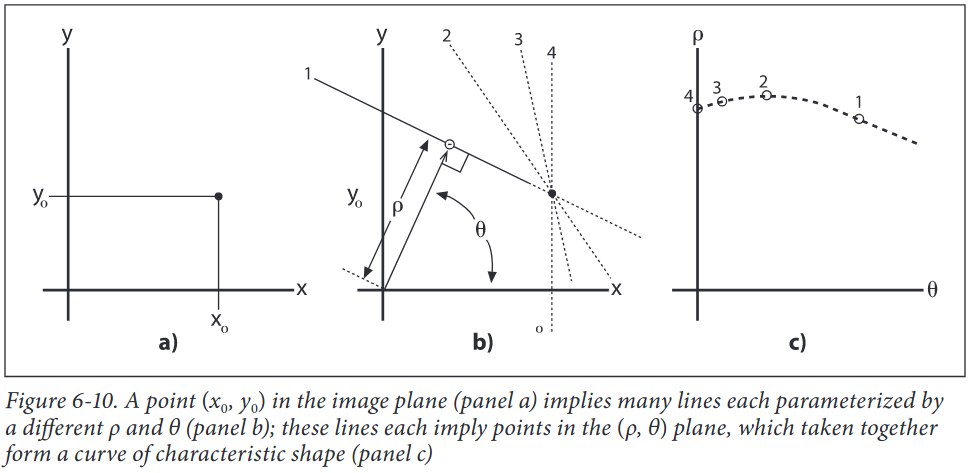

Basically, we do this for each "edge pixel" in the binary image in (a) to get a curve in (c). (c) is commonly called the `accumulator plane` since we keep accumulating (summing) the output contribution of each input point in (a). To find lines we look for local maxima in the `accumulator plane`.

## Questions

#### How do polar coordinates work? ####

We use polar coordinates $(\rho, \theta)$, with the implied line being the line passing through the indicated point but perpendicular to the radial from the origin to that point (as shown in image b)). The equation of such lines is $\rho = x\cos(\theta) + y\sin(\theta)$

#### Why polar coordinates instead of $y=ax + b$?####

Because while the slope (=$a$) can have values between -$\infty$ and +$\infty$, $\theta$ has values between 0 and 2$\pi$. So for coding applications it's better to use polar coordinates!

#### How do we get the different $\rho$ and $\theta$s ? ####

I am not sure, but this is what I imagine these algorithms are doing. If you can confirm let me know and I will update this notebook.

For each point we go through a domain of $\theta$, for example between -90 and 90 and we calculate the correspondent $\rho$ for each theta. Then we go to the accumulator matrix and we sum one there.

#### What are the different functions in OpenCV? ####

OpenCV supports three different kinds of Hough line transform: the standard Hough transform (SHT), the multiscale Hough transform (MHT), and the progres‐
sive probabilistic Hough transform (PPHT). The SHT is the algorithm we just covered. The MHT algorithm is a slight refinement that gives more accurate values for the matched lines. The PPHT is a variation of this algorithm that, among other things, computes an extent for individual lines in addition to the orientation. It is called “probabilistic” because, rather than accumulating
every possible point in the accumulator plane, it accumulates only a fraction of them. The idea is that if the peak is going to be high enough anyhow, then hitting it only a fraction of the time will be enough to find it; the result of this conjecture can be a substantial reduction in computation time.

If you have more questions let me know and I will add them here.

# Tutorial Questions

We will be using [Matplotlib](https://matplotlib.org/), [OpenCV](https://opencv.org/) and [NumPy](https://numpy.org/) so let's first import these packages:

In [ ]:
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math

## Question 1

Let's draw the edge map first. I will muliply all the values by 10 to make sure we get only integer points in our input binary image. So our new points are:
$[0, 55], [10,60], [25, 65], [35, 70], [45, 75], [60, 80], [75, 85], [90, 90], [119, 95], [143, 10]$

Let's draw our binary image:

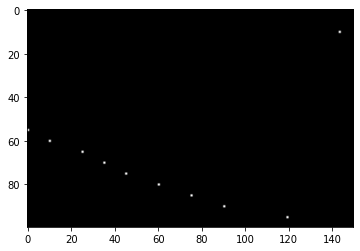

In [ ]:
# I defined the height and width based on the range of values that we have
height = 100
width = 150
# I will use unit8 as data type and set 0 as background and 255 as edge point
im_edges = np.zeros((height, width), dtype=np.uint8)
point_list = [[0, 55],
              [10,60],
              [25, 65],
              [35, 70],
              [45, 75],
              [60, 80],
              [75, 85],
              [90, 90],
              [119, 95],
              [143, 10]
             ]
# let's set 255 for the edge points
"""
    -----> (u)
    |
    |
    v (v)
"""
for pt in point_list:
    u, v = pt
    im_edges[v, u] = 255
# let's show our binary image
plt.imshow(im_edges, cmap='gray', vmin=0, vmax=255)

Very interesting, it does look like we have a line there and an outlier on the top right of the image.

Now let's use OpenCV to find that line. We will use [cv2.HoughLines()](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a). In it's most basic version you use it with the following arguments `image, rho, theta, threshold`, where `image` is our input binary image, `rho` is the distance resolution of the accumulator in pixels, `theta` the angle resolution of the accumulator in radians and `threshold` we will only get the lines that get enough votes (`>𝚝𝚑𝚛𝚎𝚜𝚑𝚘𝚕𝚍`).

 We explained in the theory what was the `accumulator plane`, remember?

3 lines found for that threshold


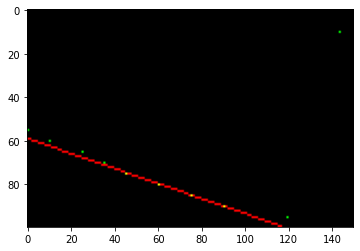

In [ ]:
# First, let's get the estimate lines
rho_res = 1
theta_res = np.pi/180
threshold = 3 # this value is very small, but that's because we only have a few images
lines = cv2.HoughLines(im_edges, rho_res, theta_res, threshold)
# Now, let's draw them
## First, let's create an image for drawing with color
im_draw = np.zeros((height, width, 3), dtype=np.uint8) # 3 channels to add color
if lines is not None:
    print('{} lines found for that threshold'.format(len(lines)))
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(im_draw, (x1,y1), (x2,y2), (255,0,0), 1)
    # Now, let's draw the points in the green channel
    im_draw_green_channel = im_draw[:,:,1]
    ## Copy only the non-zero values, which in this case will be 255 and therefore wil become green dots
    im_draw_green_channel[np.where(im_edges !=0 )] = im_edges[np.where(im_edges != 0)]
    plt.imshow(im_draw)
else:
    print('No lines found for that threshold')

The 3 lines that were found have practically the same $\rho$ and $\theta$  values so it looks like that we can only see one.

# Doing exercise 1 by hand

When doing by hand (in the tutorial question), they use $y = mx + c$ instead of polar coordinates. For each point, you will find all the possible lines that pass through that point and that will create a single straight line per point on the $m$ $c$ plane.

For example, using the point (x=0, y=5.5) we have $5.5 = m \times 0 + c$, so independently of the line's slope (m), we will always get $c = 5.5$ on the hand draw accumulator plane. If you repeat this for all the points you will get a set of lines, on the accumulator plane. The position on this plane where the lines pass the most, corresponds to the $m$ and $c$ values which corresponds to the most likely line for those points.

Example: 

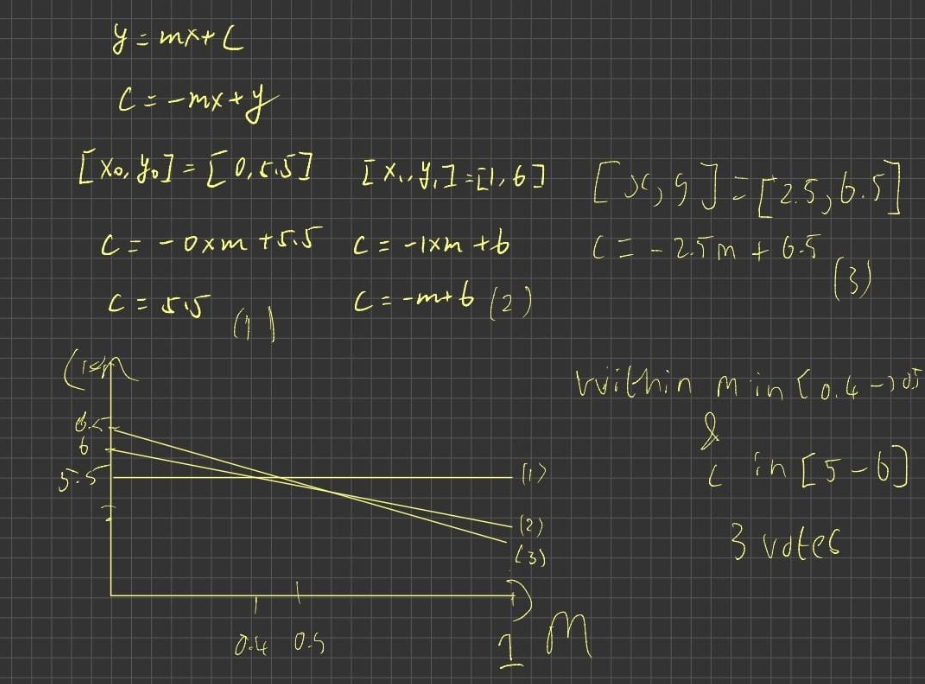


# Question 2

In this section, the image shown below will be processed by Fast Fourier Transform (FFT). Then, a 2D frequency map can be generated. The frequency increases from low to high (from the centre to the edge). With such attribute, the high frequency signal can be extracted for edge detection and the low frequency siganl can be extracted for smoothness or denoising.

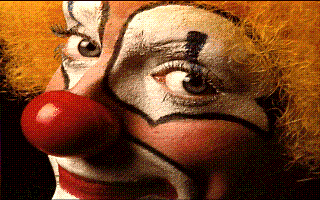

Load the image and check the shape of the image.

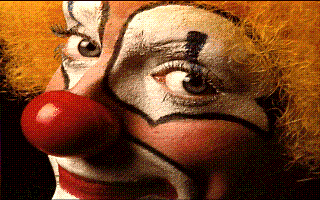

(200, 320, 3)


In [ ]:
img = cv2.imread('/content/sample_data/clown.png')
cv2_imshow(img)
print(img.shape)

Define functions (details described in the code):

1.   2D FFT
2.   2D Inverse FFT
3.   Reconstruct image from 2D frequency map (take around 4 to 5 mins)
4.   High-pass Filter
5.   Low-pass Filter





In [ ]:
def calculate_2D_fft(input):
    ft = np.fft.ifftshift(input, axes=(0,1))
    ft = np.fft.fft2(ft, axes=(0,1))
    return np.fft.fftshift(ft, axes=(0,1))

def calculate_2D_ifft(input):
    ift = np.fft.ifftshift(input, axes=(0,1))
    ift = np.fft.ifft2(ift, axes=(0,1))
    ift = np.fft.fftshift(ift, axes=(0,1))
    return ift.real

def reconstruct_img(fmap):
    '''
    fmap: array [Height, Width, channels]
    '''
    h, w, _ = fmap.shape
    # print(fmap.shape)
    # generate the centre of the frequency map
    centre = [int((h-1)/2), int((w-1)/2)]
    # generate the half left x and y coordinate
    coords_left_half = (
        (x, y) for x in range(h) for y in range(int((w-1)/2)+1)
    )
    # sort the coordinate based on the distance to centre (from close to far away)
    coords_left_half = sorted(
        coords_left_half,
        key=lambda x: calculate_distance_from_centre(x, centre)
    )
    # initialize the matrix to store the intensity from each frequency
    rec_image = np.zeros(fmap.shape)
    # initialize the matrix to store the frequency (complex type for magnitude and phase of frequency)
    individual_grating = np.zeros(
        fmap.shape, dtype="complex"
    )
    idx = 0
    for coords in coords_left_half:
        # Central column: only include if points in top half of
        # the central column
        # Reconstruct image from low frequency component to high frequency component (centre to edge)
        if not (coords[1] == centre[1] and coords[0] > centre[0]):
            idx += 1
            symm_coords = find_symmetric_coordinates(
                coords, centre
            )
            # Copy values from Fourier transform into
            # individual_grating for the pair of points in
            # current iteration
            individual_grating[coords[0], coords[1], :] = fmap[coords[0], coords[1], :]
            individual_grating[symm_coords[0], symm_coords[1], :] = fmap[symm_coords[0], symm_coords[1], :]
            # Calculate inverse Fourier transform to give the
            # reconstructed grating. Add this reconstructed
            # grating to the reconstructed image
            rec_grating = calculate_2D_ifft(individual_grating)
            rec_image += rec_grating
            # Clear individual_grating array, ready for
            # next iteration
            individual_grating[coords] = 0
            individual_grating[symm_coords] = 0

    return rec_image


def HP_filter(fmap, ws):
    '''
    fmap: array [Height, Width, channels]
    ws: scale value. window size
    '''
    h, w, _ = fmap.shape
    (c_h, c_w) = (int(h/2), int(w/2))
    F = fmap.copy()
    for i in range(h):
        for j in range(w):
            # Distance from centre is √(x^2 + y^2)
            if np.sqrt((i - c_h)**2 + (j - c_w)**2) < ws:
                F[i, j, :] = 0
    
    return F

def LP_filter(fmap, ws):
    '''
    fmap: array [Height, Width, channels]
    ws: scale value. window size
    '''
    h, w, _ = fmap.shape
    (c_h, c_w) = (int(h/2), int(w/2))
    F = fmap.copy()
    for i in range(h):
        for j in range(w):
            # Distance from centre is √(x^2 + y^2)
            if np.sqrt((i - c_h)**2 + (j - c_w)**2) > ws:
                F[i, j, :] = 0
    
    return F

    
# Below functions used in reconstruction
def calculate_distance_from_centre(coords, centre):
    # Distance from centre is √(x^2 + y^2)
    return np.sqrt(
        (coords[0] - centre[0]) ** 2 + (coords[1] - centre[1]) ** 2
    )

def find_symmetric_coordinates(coords, centre):
    # generate the symmetric coordinate 
    return (centre[0] + (centre[0] - coords[0]),
            centre[1] + (centre[1] - coords[1]))



1.   Use 2D FFT to generate the 2D frequency map.
2.   Use 2D inverse FFT



In [ ]:
fmap = calculate_2D_fft(img)
rec_img = reconstruct_img(fmap)

Display the 2D frequency map and reconstructed image

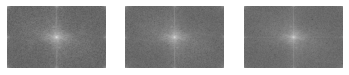

In [ ]:
# display 3-channel frequency map of RGB image
plt.subplot(131)
plt.imshow(np.log(abs(fmap[:, :, 0])), cmap='gray')
plt.axis("off")
plt.subplot(132)
plt.imshow(np.log(abs(fmap[:, :, 1])), cmap='gray')
plt.axis("off")
plt.subplot(133)
plt.imshow(np.log(abs(fmap[:, :, 2])), cmap='gray')
plt.axis("off")
plt.show()

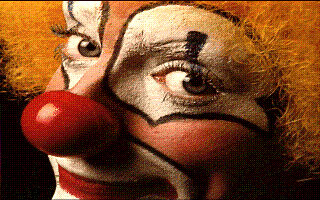

In [ ]:
# the reconstructed image
cv2_imshow(rec_img)

Edge Detection with High-pass Filter

In [ ]:
# you can control the window size to decide the amount of high frequency signal
fmap_HP = HP_filter(fmap, 15)
rec_img = reconstruct_img(fmap_HP)

Display the high frequency components of 2D frequency map and Edge Detection.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


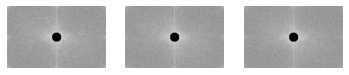

In [ ]:
fmap_display = np.log(abs(fmap_HP))
mask = (fmap_display == -math.inf)
fmap_display[mask] = 0

# display the 3-channel high frequency part of RGB image
plt.subplot(131)
plt.imshow(fmap_display[:, :, 0], cmap='gray')
plt.axis("off")
plt.subplot(132)
plt.imshow(fmap_display[:, :, 1], cmap='gray')
plt.axis("off")
plt.subplot(133)
plt.imshow(fmap_display[:, :, 2], cmap='gray')
plt.axis("off")
plt.show()

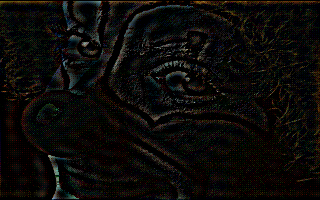

In [ ]:
# The edge detection generated by high frequency reconstruction
cv2_imshow(rec_img)

Smoothing the image with Low-pass Filter

In [ ]:
# you can control the window size to decide the amount of low frequency signal
fmap_LP = LP_filter(fmap, 30)
rec_img = reconstruct_img(fmap_LP)

Display the low frequency components of 2D frequency map and smoothness (or denoising).

In [ ]:
fmap_display = np.log(abs(fmap_LP))
mask = (fmap_display == -math.inf)
fmap_display[mask] = 0

# display the 3-channel low frequency part of RGB image
plt.subplot(131)
plt.imshow(fmap_display[:, :, 0], cmap='gray')
plt.axis("off")
plt.subplot(132)
plt.imshow(fmap_display[:, :, 1], cmap='gray')
plt.axis("off")
plt.subplot(133)
plt.imshow(fmap_display[:, :, 2], cmap='gray')
plt.axis("off")
plt.show()

NameError: ignored

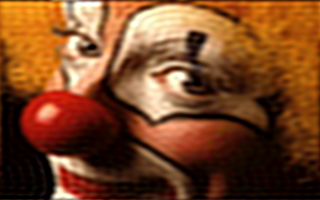

In [ ]:
# display the smoothed image generated by low-frequency part 
cv2_imshow(rec_img)

# Question 3

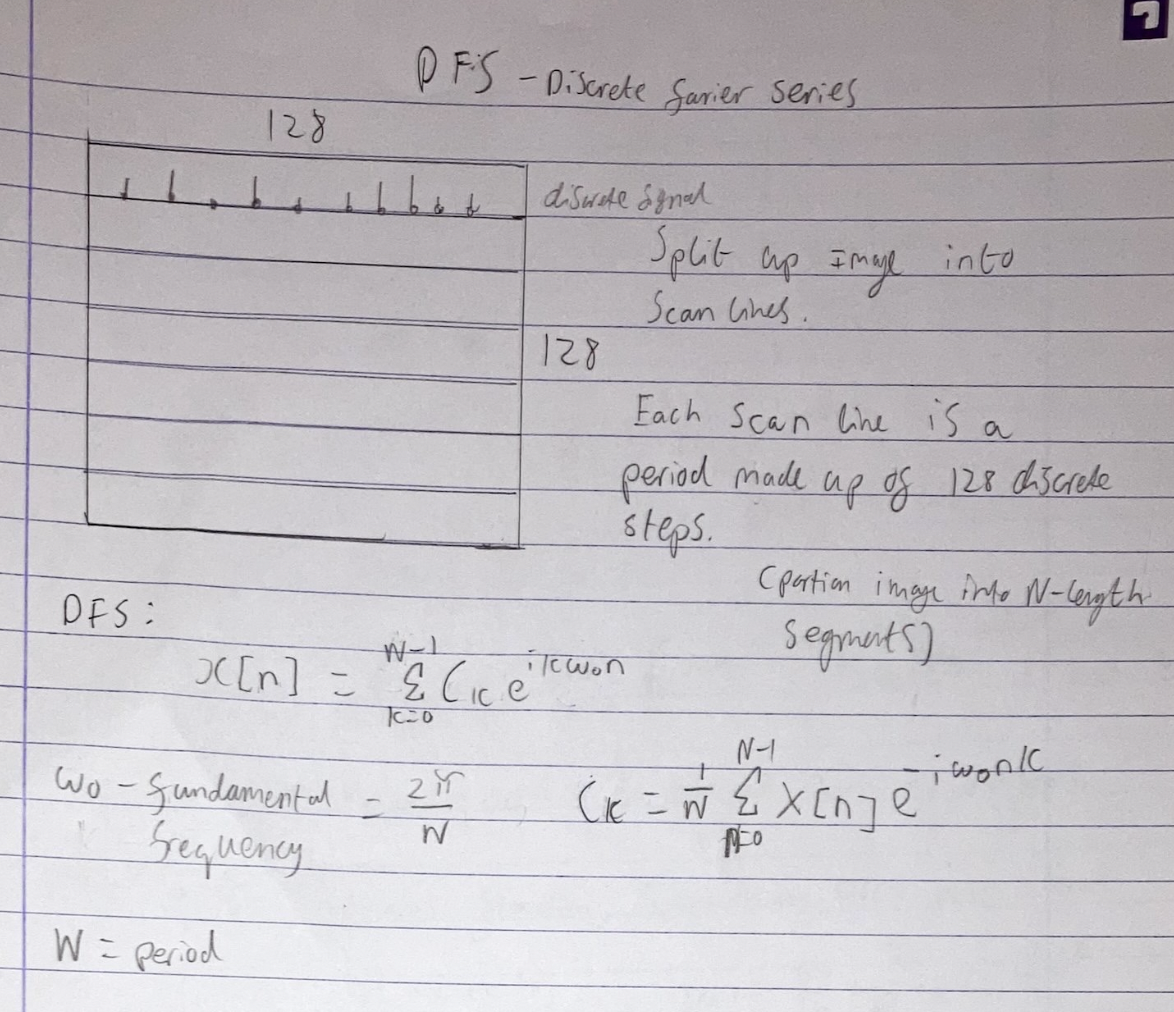

So for we can treat each scan line as an individual function with period, width (N=128 in this case).

$I(x) = a_{0} + a_{1}cos(ax) + b_{1}sin(ax) + a_{2}cos(2ax)+b_{2}sin(2ax)+...$

If we rewrite in terms of x and I(x) we get:

$I(x) = \sum_{k=0}^{N-1}C_{k}e^{ik\omega_{0}x}$

Where,

$\omega_{0}=2\pi/N$,
N = Period

$C_{k}=\frac{1}{N}\sum_{x=0}^{N-1}I(x)e^{ik\omega_{0}x}$

a)

From the above equation we know that

$kax = k\omega_{0}x$

so a is the fundamental frequency, $\omega_{0}$.

We know $\omega_{0}=2\pi/N$ and so $a=2\pi/128=\pi/64.$

b)

In part b we have to make some assumptions.

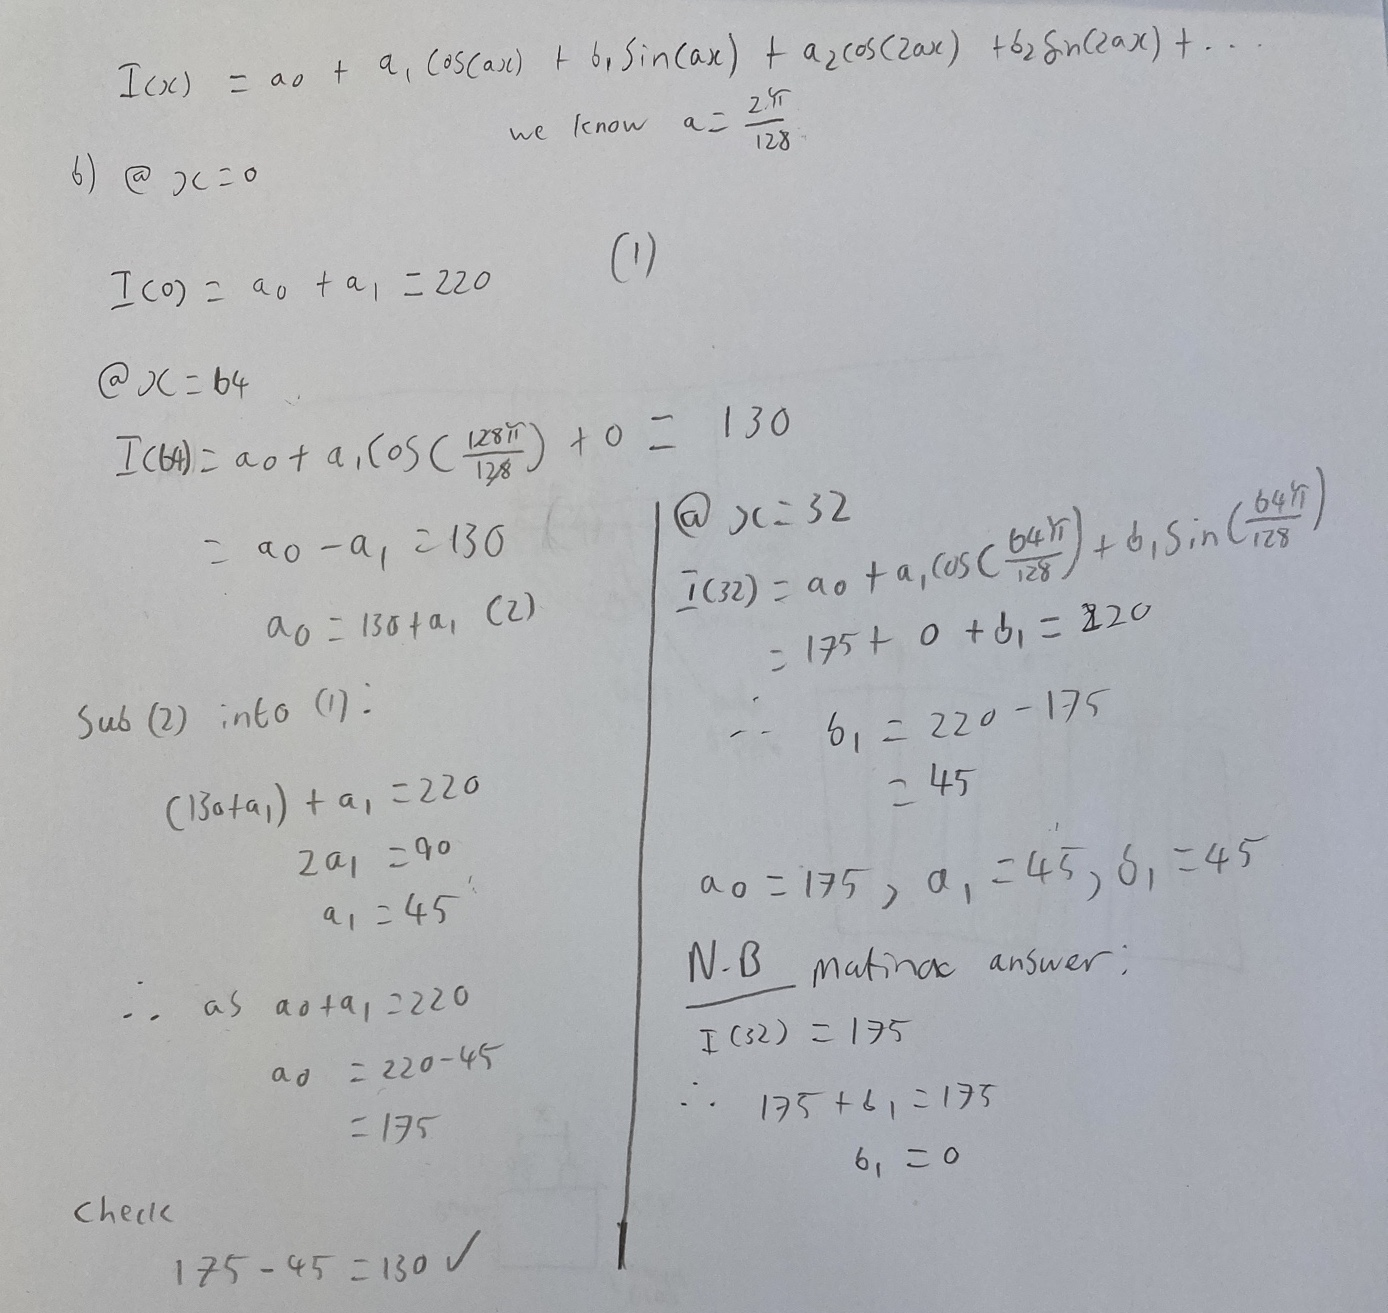

N.B Matina says I(32) is 175, personally I think it is 220. Answer states b1=0.

Below is if you wanted to actually work out the coefficients...

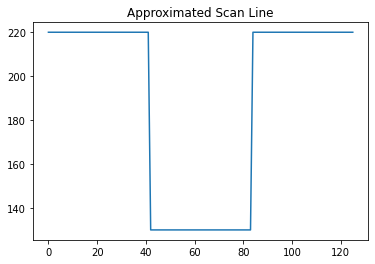

(126,)


In [ ]:
_1 = np.repeat(220, 128//3)
_2 = np.repeat(130, 128//3)
_3 = np.repeat(220, 128//3)
scan_l = np.concatenate((_1, _2, _3))
plt.figure()
plt.plot(scan_l)
plt.title('Approximated Scan Line')
plt.show()
print(scan_l.shape)

In [ ]:
"""
Calculating fourier series coefficients using Rieman Sum
https://stackoverflow.com/questions/4258106/how-to-calculate-a-fourier-series-in-numpy
"""
# import numpy as np
# def cn(n):
#    c = y*np.exp(-1j*2*n*np.pi*time/period)
#    return c.sum()/c.size

# def f(x, Nh):
#    f = np.array([2*cn(i)*np.exp(1j*2*i*np.pi*x/period) for i in range(1,Nh+1)])
#    return f.sum()

# y2 = np.array([f(t,50).real for t in time])

# plot(time, y)
# plot(time, y2)

'\nCalculating fourier series coefficients using Rieman Sum\nhttps://stackoverflow.com/questions/4258106/how-to-calculate-a-fourier-series-in-numpy\n'

Obvioulsy the length of this is no longer 128 but instead 126, due to rounding errors.

We can use the above equation for the coefficients and make an approximation...

$C_{k}=\frac{1}{N}\sum_{x=0}^{N-1}I(x)e^{ik\omega_{0}x} =\frac{1}{128}\sum_{x=0}^{127}I(x)e^{ik\omega_{0}x} $

Which when split up would look like:

$C_{k}=\frac{1}{128}(\sum_{x=0}^{42}220e^{ik\omega_{0}x}+\sum_{x=43}^{85}130e^{ik\omega_{0}x}+ \sum_{x=86}^{127}220e^{ik\omega_{0}x})$


To split up into $a_{k}$ and $b_{k}$ we can use the equations:

$C_{k}=\frac{a_{k}-ib_{k}}{2}$

$C_{k}^{*}=\frac{a_{k}+ib_{k}}{2}$

- As a side note, if you wanted to solve the summations by hand you could use the euler-macluarin formula to represent sums as integrals.